In [3]:
import os
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import tqdm 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Data (CelebA and MNIST)
- Source: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg

In [8]:
# !unzip /content/drive/My\ Drive/img_align_celeba.zip

In [9]:
!mkdir celeba

In [11]:
!mv img_align_celeba/ celeba/

In [13]:
root = "./celeba/"

In [15]:
BATCH_SIZE = 128
IM_HEIGHT = 64
IM_WIDTH = 64
NUM_WORKERS = 2

In [16]:
# apply transoformation
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IM_HEIGHT),
    torchvision.transforms.CenterCrop(IM_HEIGHT),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [17]:
# read the data 
data = torchvision.datasets.ImageFolder(root=root, transform=data_transform)

In [18]:
# data loader 
data_loader = torch.utils.data.DataLoader(
    dataset=data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

##### Visualize Samples

In [19]:
def show_grid(grid):
    plt.figure(figsize=(16, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


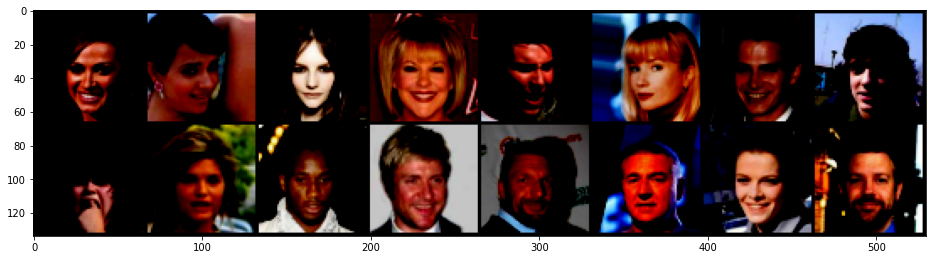

In [20]:
x, y = next(iter(data_loader))
grid = torchvision.utils.make_grid(x[:16], nrow=8)
show_grid(grid)

In [21]:
print(x.size(), y.size())

torch.Size([128, 3, 64, 64]) torch.Size([128])


### DCGAN

###### Weight Intialization

In [22]:
"""
From the DCGAN paper, the authors specify that all model weights shall be randomly 
initialized from a Normal distribution with mean=0, stdev=0.02.
"""


# custom weights initialization called on netG and netD
# taken from Pytorch tutorial

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [78]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=100, hidden_channels=[256, 128, 64], out_channels=3):
        
        super(Generator, self).__init__()
            
        modules = []
        
        # noise.siz() : [batch, channel, 1, 1] -> [batch, 512, 4, 4]
        modules.append(self.deconv_block(
            in_channels=z_dim, 
            out_channels=512, 
            kernel_size=4,
            stride=1,
            padding=0, 
            bias=False))
        
        # [batch, 512, 4, 4] -> [batch, 256, 8, 8] -> [batch, 128, 16, 16] -> [batch, 64, 32, 32]
        in_channels = 512
        for h_dim in hidden_channels:
            modules.append(self.deconv_block(
                in_channels=in_channels, 
                out_channels=h_dim,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ))
            in_channels=h_dim
        
        # [batch, 64, 32, 32] -> [batch, 3, 64, 64] 
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=in_channels, 
                    out_channels=out_channels, 
                    kernel_size=4,
                    stride=2,
                    padding=1,
                    bias=False
                ),
                nn.Tanh()
            )
        )
        
        self.net = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.net(x)
            
    
    
    def deconv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False):
        layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU()
        )
        return layer

### Discriminator

In [106]:
class Discriminator(nn.Module):
    
    def __init__(self, in_channels=3, hidden_channels=[64, 128, 256, 512], num_classes=1):
        
        super(Discriminator, self).__init__()
        
        modules = []
        for h_dim in hidden_channels:
            modules.append(self.conv_block(in_channels=in_channels, out_channels=h_dim))
            in_channels=h_dim
            
        modules.append(
            nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, 
                    out_channels=num_classes, 
                    kernel_size=4,
                    stride=2,
                    padding=0,
                    bias=False
                ),
                nn.Sigmoid()
            )
        )
        self.net = nn.Sequential(*modules)
        
        
    
    def forward(self, x):
        return self.net(x)
    
    def conv_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False):
        layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding, 
                bias=bias
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            
        )
        return layer

### Training

In [114]:
import torch.utils.tensorboard as tensorboard

In [124]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = tensorboard.SummaryWriter()
lr = 1e-3
epochs = 10
num_batches = len(data_loader)
noise_dim = 100
in_channel = 3
out_channel = 3
real = 1
fake = 0

In [125]:
# create model and initialize the weight
netG = Generator().to(device)
netD = Discriminator().to(device)
## intialize the weight
netG.apply(weights_init)
netD.apply(weights_init)
print("Initialized ...")

Initialized ...


In [126]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# noise for testing 
fixed_noise = torch.randn(16, noise_dim, 1, 1, device=device)

real_label = 1
fake_label = 0


# Setup Adam optimizers for both G and D
d_optimizer = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

epoch 0 | step 0 | d_loss 1.8516 | g_loss 20.1640 | D(x) 0.5200 | D(G(z)) 0.5783/0.0000


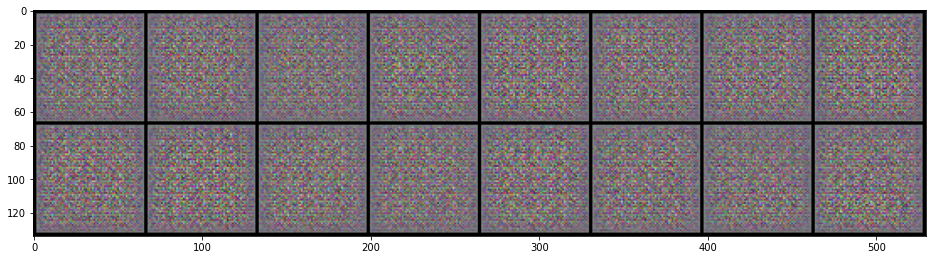

Step:  63%|██████▎   | 1000/1583 [02:43<01:43,  5.62it/s]

epoch 0 | step 1000 | d_loss 1.0485 | g_loss 2.0512 | D(x) 0.6053 | D(G(z)) 0.3346/0.1547


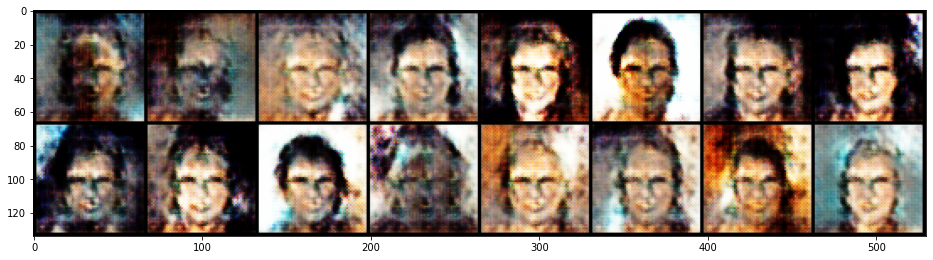

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 0 | Step 1583 | D_loss 1.3296666396799453%.4f | G_loss 2.5233005061604445


Step:  26%|██▋       | 417/1583 [01:08<02:58,  6.52it/s]

epoch 1 | step 2000 | d_loss 1.1486 | g_loss 1.5389 | D(x) 0.4382 | D(G(z)) 0.1268/0.2614


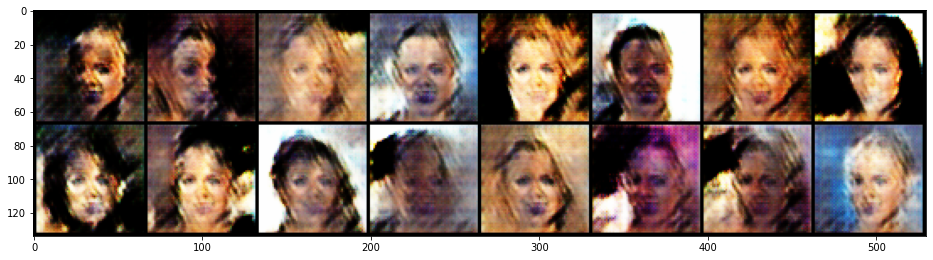

Step:  90%|████████▉ | 1417/1583 [03:49<00:29,  5.66it/s]

epoch 1 | step 3000 | d_loss 1.5675 | g_loss 3.1668 | D(x) 0.8740 | D(G(z)) 0.7111/0.0591


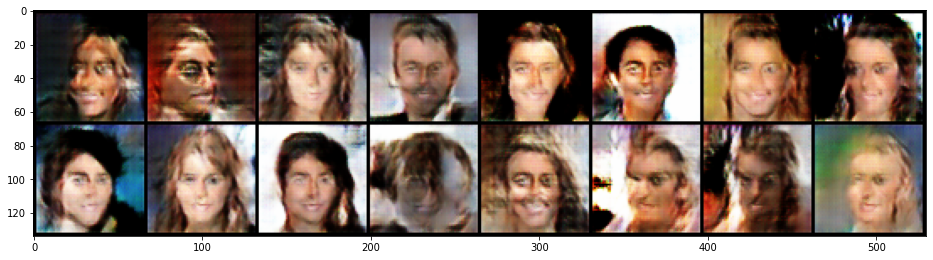

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 1 | Step 3166 | D_loss 1.1711618485739919%.4f | G_loss 2.2407674371292527


Step:  53%|█████▎    | 833/1583 [02:15<02:00,  6.22it/s]

epoch 2 | step 4000 | d_loss 1.0871 | g_loss 2.0838 | D(x) 0.6938 | D(G(z)) 0.4471/0.1520


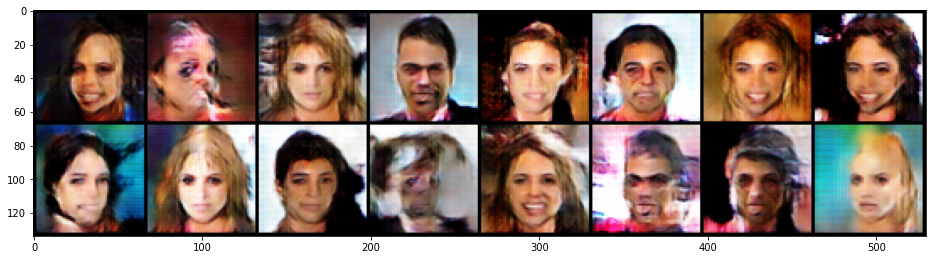

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 2 | Step 4749 | D_loss 1.1572179289385254%.4f | G_loss 1.9993282497795186


Step:  16%|█▌        | 251/1583 [00:40<03:22,  6.57it/s]

epoch 3 | step 5000 | d_loss 1.3803 | g_loss 1.6972 | D(x) 0.7005 | D(G(z)) 0.5697/0.2994


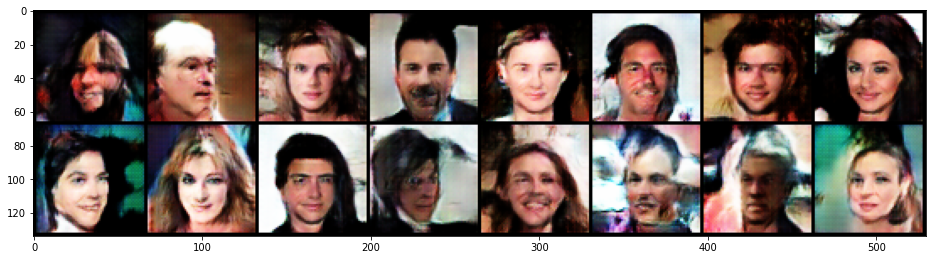

Step:  79%|███████▉  | 1251/1583 [03:22<00:59,  5.58it/s]

epoch 3 | step 6000 | d_loss 1.0589 | g_loss 1.4353 | D(x) 0.4805 | D(G(z)) 0.1773/0.2865


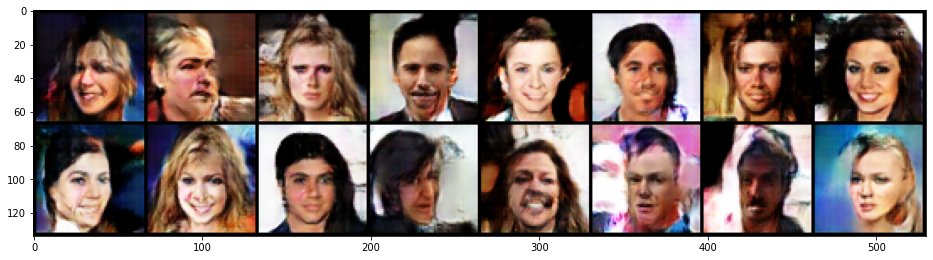

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 3 | Step 6332 | D_loss 1.1025071273630207%.4f | G_loss 1.9750078511215505


Step:  42%|████▏     | 668/1583 [01:47<02:12,  6.93it/s]

epoch 4 | step 7000 | d_loss 0.8323 | g_loss 2.4838 | D(x) 0.7309 | D(G(z)) 0.3481/0.1083


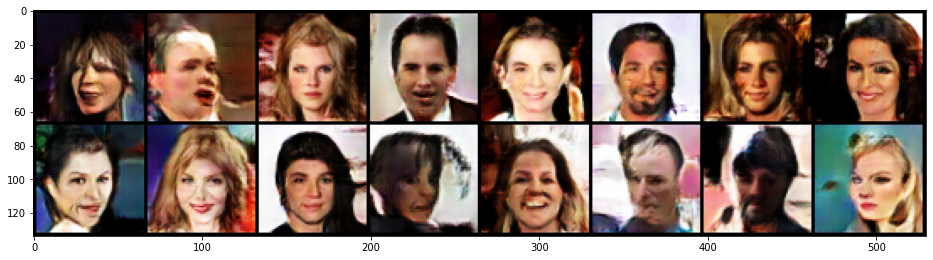

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 4 | Step 7915 | D_loss 0.9897665158149492%.4f | G_loss 2.200359809920145


Step:   5%|▌         | 85/1583 [00:13<03:42,  6.74it/s]

epoch 5 | step 8000 | d_loss 0.8440 | g_loss 1.5472 | D(x) 0.6063 | D(G(z)) 0.2097/0.2620


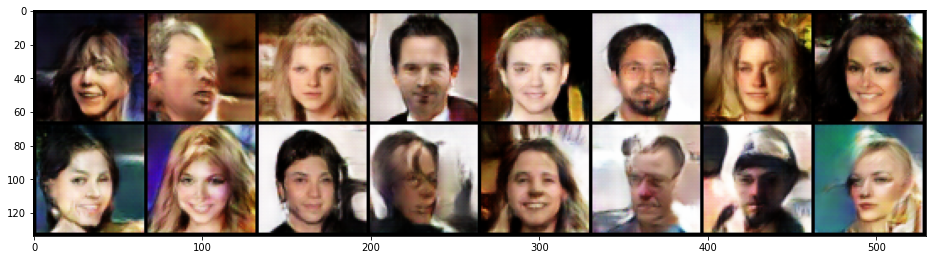

Step:  69%|██████▊   | 1085/1583 [02:55<01:09,  7.12it/s]

epoch 5 | step 9000 | d_loss 1.0746 | g_loss 3.9360 | D(x) 0.9002 | D(G(z)) 0.5574/0.0288


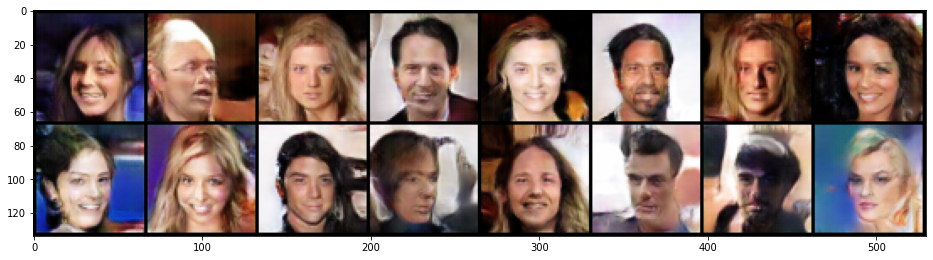

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 5 | Step 9498 | D_loss 0.8609041548837082%.4f | G_loss 2.5336755629245307


Step:  32%|███▏      | 502/1583 [01:20<02:45,  6.54it/s]

epoch 6 | step 10000 | d_loss 1.0407 | g_loss 4.6392 | D(x) 0.9326 | D(G(z)) 0.5533/0.0162


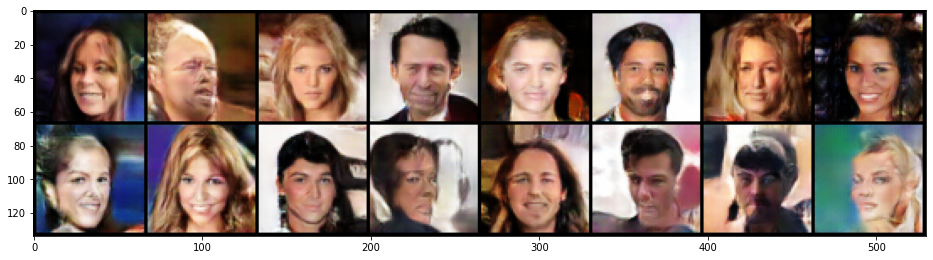

Step:  95%|█████████▍| 1502/1583 [04:01<00:11,  7.14it/s]

epoch 6 | step 11000 | d_loss 0.5287 | g_loss 2.1945 | D(x) 0.7170 | D(G(z)) 0.1045/0.1725


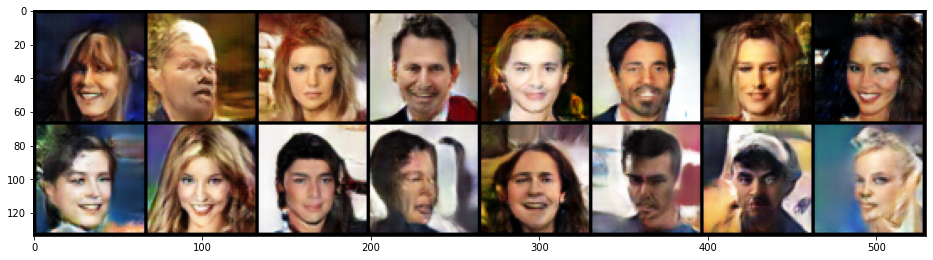

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 6 | Step 11081 | D_loss 0.7310895640508931%.4f | G_loss 2.8862827089076846


Step:  58%|█████▊    | 919/1583 [02:27<01:39,  6.66it/s]

epoch 7 | step 12000 | d_loss 0.3552 | g_loss 3.1377 | D(x) 0.8580 | D(G(z)) 0.1493/0.0675


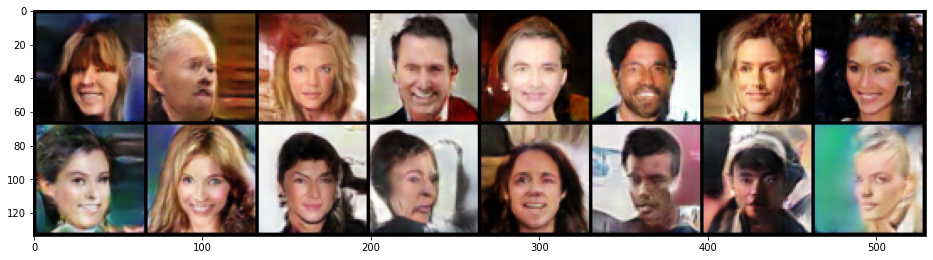

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 7 | Step 12664 | D_loss 0.6201706888908385%.4f | G_loss 3.328991314922227


Step:  21%|██        | 336/1583 [00:54<03:27,  6.02it/s]

epoch 8 | step 13000 | d_loss 1.1476 | g_loss 1.4110 | D(x) 0.4936 | D(G(z)) 0.1465/0.3502


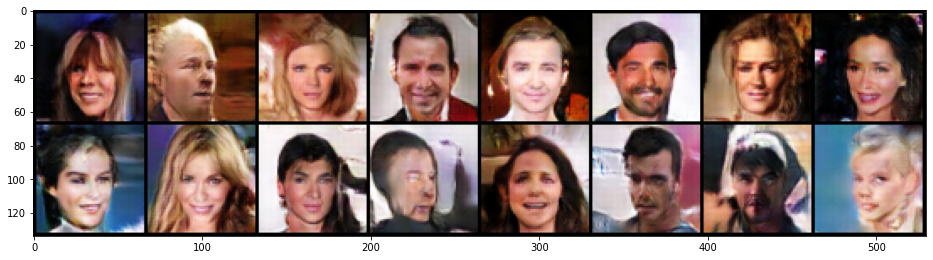

Step:  84%|████████▍ | 1336/1583 [03:34<00:36,  6.71it/s]

epoch 8 | step 14000 | d_loss 0.3205 | g_loss 3.1308 | D(x) 0.8601 | D(G(z)) 0.1234/0.0780


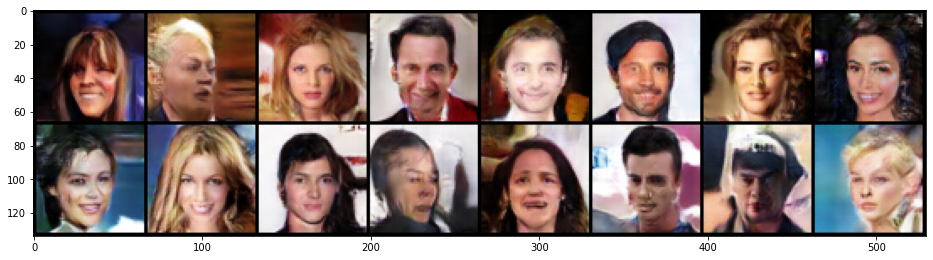

Step:   0%|          | 0/1583 [00:00<?, ?it/s]

Epoch 8 | Step 14247 | D_loss 0.5486027417929205%.4f | G_loss 3.624544333906601


Step:  48%|████▊     | 753/1583 [02:00<02:05,  6.62it/s]

epoch 9 | step 15000 | d_loss 0.3016 | g_loss 5.2409 | D(x) 0.9612 | D(G(z)) 0.1928/0.0087


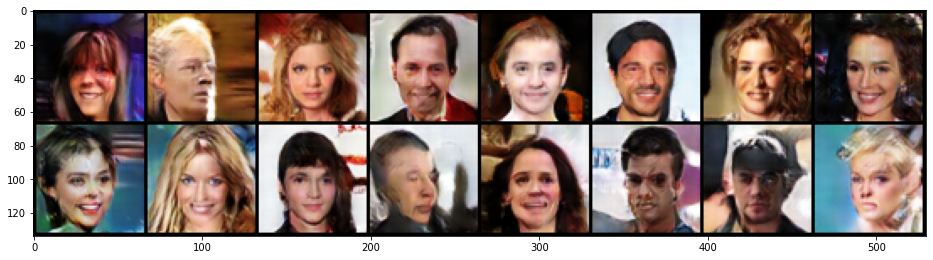

Epoch: 100%|██████████| 10/10 [42:33<00:00, 254.55s/it]

Epoch 9 | Step 15830 | D_loss 0.5063766892375784%.4f | G_loss 3.882885631842189


In [127]:
epoch_progress = tqdm.tqdm(total=epochs, desc="Epoch", position=0)
steps = 0

for epoch in range(epochs):
  
  steps_progress = tqdm.tqdm(total=num_batches, desc="Step", position=0)
  g_epoch_loss = []
  d_epoch_loss = []

  for i, (images, _) in enumerate(data_loader):
    

    """
      ---Discriminator Training---
    """
    d_optimizer.zero_grad()
    images = images.to(device)
    batch = images.size(0)
    
    # Training on real data
    label = torch.full((batch,), real_label, device=device)

    output = netD(images).view(-1)
    d_loss_real = criterion(output, label)
    d_loss_real.backward()
    D_x = output.mean().item()


    # Training on fake data
    noise = torch.randn(batch, noise_dim, 1, 1, device=device)
    fake = netG(noise)

    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)
    d_loss_fake = criterion(output, label)
    d_loss_fake.backward()
    D_G_z1 = output.mean().item()
    d_loss = d_loss_real + d_loss_fake
    d_optimizer.step()


    """
      ---Generator Training---
    """

    g_optimizer.zero_grad()

    label.fill_(real_label)

    output = netD(fake).view(-1)
    g_loss = criterion(output, label)
    g_loss.backward()
    D_G_z2 = output.mean().item()
    g_optimizer.step()



    if steps%1000==0:
      print(f'epoch {epoch} | step {steps} | d_loss {d_loss.item():.4f} | g_loss {g_loss.item():.4f} | D(x) {D_x:.4f} | D(G(z)) {D_G_z1:.4f}/{D_G_z2:.4f}')
      with torch.no_grad():
        fake = fake = netG(fixed_noise).detach().cpu()
      show_grid(torchvision.utils.make_grid(fake[:16], padding=2, normalize=True))
    
    steps += 1
    steps_progress.update(1)

    writer.add_scalar("step loss", g_loss.item(), steps)
    writer.add_scalar("step loss", d_loss.item(), steps)
    g_epoch_loss.append(g_loss.item())
    d_epoch_loss.append(d_loss.item())
  
  d_loss_avg = sum(d_epoch_loss)/len(d_epoch_loss)
  g_loss_avg = sum(g_epoch_loss)/len(g_epoch_loss)
  print(f'Epoch {epoch} | Step {steps} | D_loss {d_loss_avg:.4f} | G_loss {g_loss_avg:.4f}')
  writer.add_scalar("epoch loss", d_loss_avg, steps)
  writer.add_scalar("epoch loss", g_loss_avg, steps)
  epoch_progress.update(1)